In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam, lr_scheduler
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import seaborn as sns


## Preliminary

In [2]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))
k = 1000
BATCH_SIZE = 100

## Dataset

In [3]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    full_dataset = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                full_dataset.append((aptamer.encode("utf-8"), peptide.encode("utf-8"), 1))
    full_dataset = list(set(full_dataset)) #removed duplicates
    return full_dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, batch_size):
        super(Dataset, self).__init__() 
        num_batches = len(dataset)//batch_size
        dataset = dataset[:num_batches*batch_size]
        self.dataset = dataset 
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        aptamer, peptide, label = self.dataset[idx]
        return aptamer, peptide, label
    

aptamer_dataset_file = "../data/aptamer_dataset.json"
positive_dataset = construct_dataset()
n = len(positive_dataset)

In [4]:
positive_dataset[1]

('CGCCTTTAATGTGACGGTTAGGGATGCCCCTATCGACTAG', 'MLERPTGD', 1)

## NN Model

In [5]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        nn.init.zeros_(m.bias.data)

In [6]:
class DoubleConvNet(nn.Module):
    def __init__(self):
        super(DoubleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 1000, (5,4)) #similar to 5-gram
        self.cnn_apt_2 = nn.Conv2d(1000, 100, 1)
        self.cnn_pep_1 = nn.Conv2d(1, 500, (5,20))
        self.cnn_pep_2 = nn.Conv2d(500, 10, 1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(3640, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.cnn_apt_2(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.cnn_pep_2(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class MoreComplexNet(nn.Module):
    def __init__(self):
        super(MoreComplexNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 500, 1) #similar to 5-gram
        self.cnn_apt_2 = nn.Conv2d(500, 1000, 1)
        self.cnn_apt_3 = nn.Conv2d(1000, 500, 2)
        self.cnn_apt_4 = nn.Conv2d(500, 100, 2)
        self.cnn_apt_5 = nn.Conv2d(100, 10, 2)
        
        self.cnn_pep_1 = nn.Conv2d(1, 250, 1)
        self.cnn_pep_2 = nn.Conv2d(250, 500, 1)
        self.cnn_pep_3 = nn.Conv2d(500, 250, 3)
        self.cnn_pep_4 = nn.Conv2d(250, 100, 2)
        self.cnn_pep_5 = nn.Conv2d(100, 10, 2)
        
        self.relu = nn.ReLU()
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.relu, self.cnn_apt_2, self.relu, self.cnn_apt_3, self.relu, self.cnn_apt_4, self.relu, self.cnn_apt_5)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.relu, self.cnn_pep_2, self.relu, self.cnn_pep_3, self.relu, self.cnn_pep_4, self.relu, self.cnn_pep_5)
        
        
        self.fc1 = nn.Linear(101000, BATCH_SIZE*2)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        return x
    
    def loss(self, prediction, label):
        criterion = nn.CrossEntropyLoss()
        return criterion(prediction, label)

## Sampling methods

In [8]:
# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S' contains S with double the size of S (domain for Importance Sampling)
# Return S_prime, and S_new (all unseen samples)
def get_S_new(k):
    S_new = []
    for _ in range(k):
        pair = (get_x(), get_y(), 0)
        S_new.append(pair)
    return S_new

S_new = get_S_new(n) #use for sgd and eval
print("Length of S_new: ", len(S_new))

('Length of S_new: ', 591309)


## Helper methods

In [9]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, ls):
    aptamers = np.zeros((BATCH_SIZE, 40, 4))
    peptides = np.zeros((BATCH_SIZE, 8, 20))
    
    for i in range(len(apt)):
        aptamers[i] = one_hot(apt[i], seq_type='aptamer')
        peptides[i] = one_hot(pep[i], seq_type='peptide')
    

    aptamers = torch.FloatTensor(np.reshape(aptamers, (BATCH_SIZE, 1, aptamers.shape[1], aptamers.shape[2]))).cuda() #(1, 1, 40, 4)
    peptides = torch.FloatTensor(np.reshape(peptides, (BATCH_SIZE, 1, peptides.shape[1], peptides.shape[2]))).cuda() #(1, 1, 8, 20)
    labels = []
    for l in ls:
        labels.append(l.item())
    labels = torch.LongTensor(np.asarray(labels))
    return aptamers, peptides, labels.cuda()

## Construct Train/TestLoaders

In [10]:
full_dataset = positive_dataset + S_new
random.shuffle(full_dataset)

In [11]:
full_dataset[:2]

[('ACGTGCTGGAAGAGATTTTCAACCACGGTATTGCATTCTA', 'MRSNTFRL', 1),
 ('TGTTTGGTCGGGACGAATTACAACCTACTCATTAGAAAGT', 'MLGLPFEE', 0)]

In [12]:
train_dataset = Dataset(full_dataset[:int(0.8*len(full_dataset))], BATCH_SIZE)
validation_dataset = Dataset(full_dataset[int(0.8*len(full_dataset)):int(0.9*len(full_dataset))], BATCH_SIZE)
test_dataset = Dataset(full_dataset[int(0.9*len(full_dataset)):], BATCH_SIZE)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
print("Length of train dataset: ", len(train_dataset))
print("Length of val dataset: ", len(validation_dataset))
print("Length of test dataset: ", len(test_dataset))

('Length of train dataset: ', 946000)
('Length of val dataset: ', 118200)
('Length of test dataset: ', 118200)


## Binary Classification

In [13]:
def binary_classification(t=5, lr=1e-5, decay=0.5):
    model = MoreComplexNet()
    model.apply(weights_init)
    model.cuda()
        
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=decay)
    
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(t):
        model.train()
        print("Epoch: ", epoch)
        for i, batch in enumerate(tqdm.tqdm(train_loader)):
            aptamers = list(batch[0])
            peptides = list(batch[1])
            labels = list(batch[2])
            
            x, y, labels = convert(aptamers, peptides, labels)

            optimizer.zero_grad()
            output = model(x, y)
            
            
            output = output.view((BATCH_SIZE, 2))
            output = F.normalize(output, dim=1)
            loss = model.loss(output, labels)  
            
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

            # Testing loop
            if i % 1000 == 0:
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for j, batch in enumerate(val_loader):
                        aptamers = list(batch[0])
                        peptides = list(batch[1])
                        labels = list(batch[2])

                        x, y, labels = convert(aptamers, peptides, labels)

                        output = model(x, y)
                        output = output.view((BATCH_SIZE, 2))
                        val_loss = model.loss(output, labels)
                        val_losses.append(val_loss)
                        
                        
                        pred = torch.argmax(output, dim=1)
                        pred = pred.cpu().detach().numpy()
                        labels = labels.cpu().detach().numpy()
                        for j in range(pred.shape[0]):
                            if pred[j] == labels[j]:
                                correct += 1

                        total += BATCH_SIZE

                print('Accuracy of the network after ' + str(i) + ' iterations on the validation samples: %d %%' % (100* correct/total))
                _, ax = plt.subplots()
                ax.plot(train_losses, 'g', label='Train loss')
                ax.plot(val_losses, 'b', label='Val loss')
                ax.set_title('Loss after ' + str(i) + " iterations ")
                ax.legend()
                plt.show()
        


('Initial learning rate: ', 0.001)


  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 0)
Accuracy of the network after 0 iterations on the validation samples: 50 %


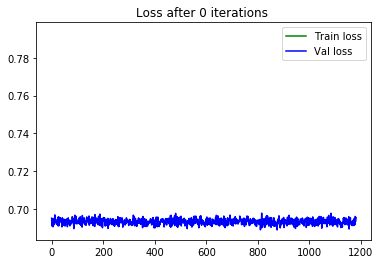

 11%|█         | 1000/9460 [01:30<05:59, 23.56it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 49 %


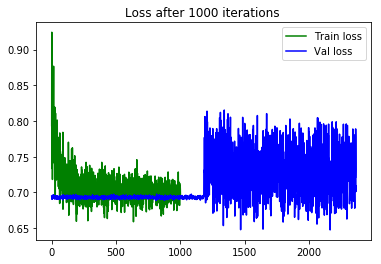

 21%|██        | 2000/9460 [02:50<05:17, 23.49it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 50 %


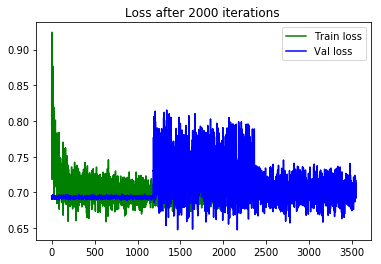

 32%|███▏      | 3000/9460 [04:10<04:35, 23.43it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 50 %


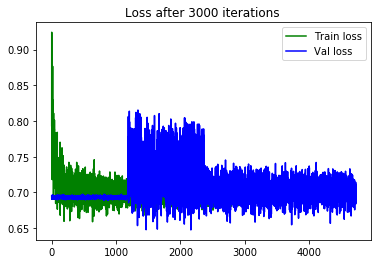

 42%|████▏     | 4000/9460 [05:30<03:53, 23.38it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 49 %


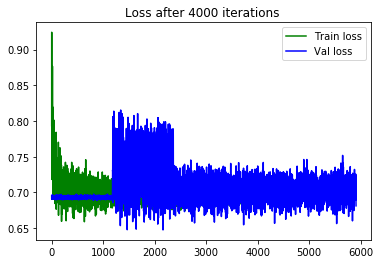

 53%|█████▎    | 5000/9460 [06:50<03:10, 23.43it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 49 %


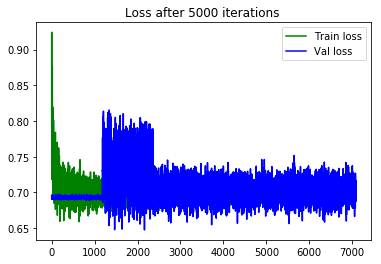

 63%|██████▎   | 6000/9460 [08:10<02:27, 23.44it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 49 %


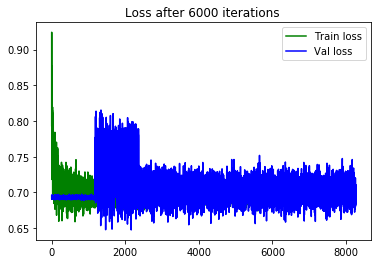

 74%|███████▍  | 7000/9460 [09:30<01:45, 23.41it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 50 %


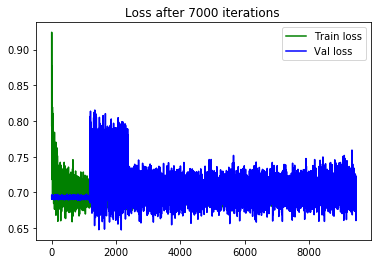

 85%|████████▍ | 8000/9460 [10:40<01:02, 23.47it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 49 %


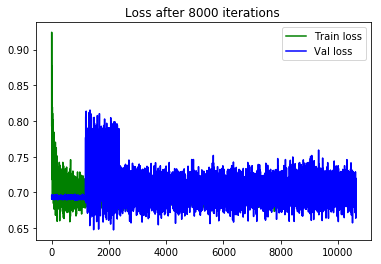

 95%|█████████▌| 9000/9460 [12:00<00:19, 23.46it/s]  

Accuracy of the network after 9000 iterations on the validation samples: 49 %


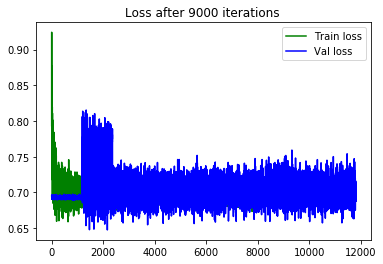

  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 1)
Accuracy of the network after 0 iterations on the validation samples: 50 %


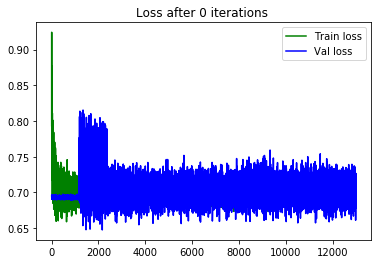

 11%|█         | 1000/9460 [01:30<06:01, 23.41it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 49 %


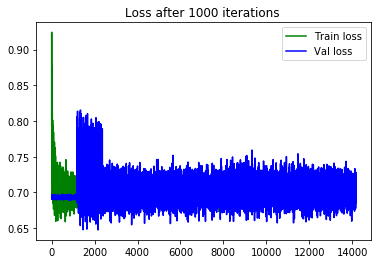

 21%|██        | 2000/9460 [02:50<05:18, 23.41it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 50 %


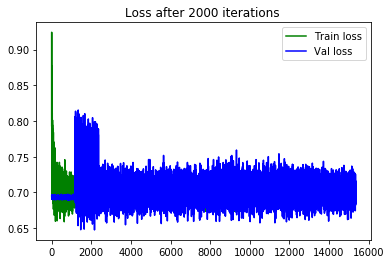

 32%|███▏      | 3000/9460 [04:10<04:35, 23.45it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 50 %


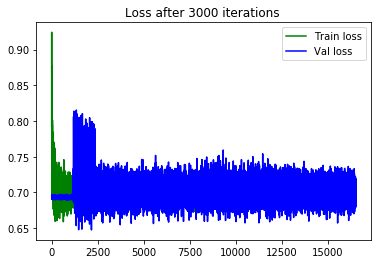

 42%|████▏     | 4000/9460 [05:30<03:52, 23.50it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 49 %


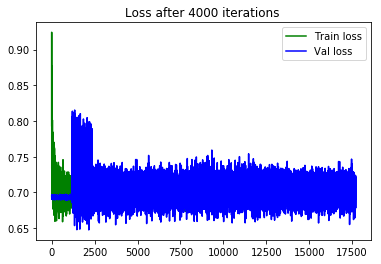

 53%|█████▎    | 5000/9460 [06:50<03:10, 23.39it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 49 %


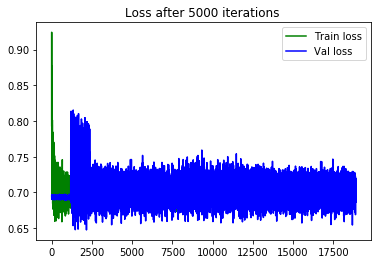

 63%|██████▎   | 6000/9460 [08:10<02:27, 23.42it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 49 %


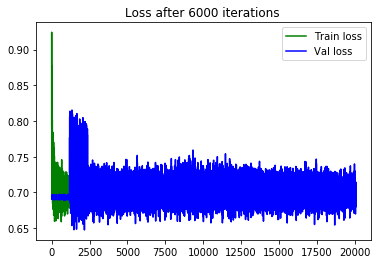

 74%|███████▍  | 7000/9460 [09:30<01:45, 23.40it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 50 %


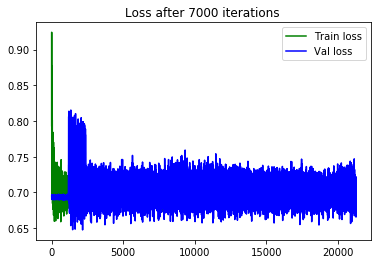

 85%|████████▍ | 8000/9460 [10:50<01:02, 23.43it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 49 %


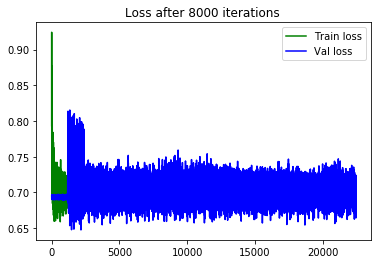

 95%|█████████▌| 9000/9460 [12:10<00:19, 23.40it/s]  

Accuracy of the network after 9000 iterations on the validation samples: 49 %


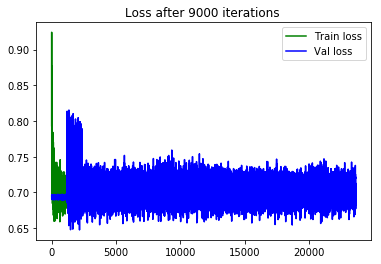

  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 2)
Accuracy of the network after 0 iterations on the validation samples: 50 %


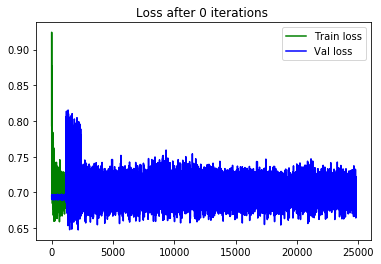

 11%|█         | 1000/9460 [01:30<06:00, 23.45it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 50 %


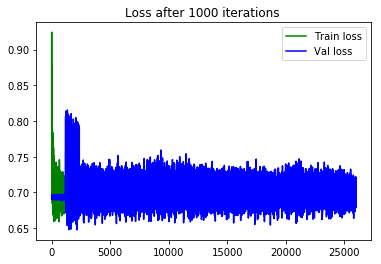

 21%|██        | 2000/9460 [02:50<05:18, 23.45it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 50 %


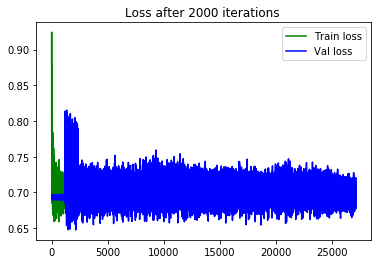

 32%|███▏      | 3000/9460 [04:10<04:36, 23.38it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 50 %


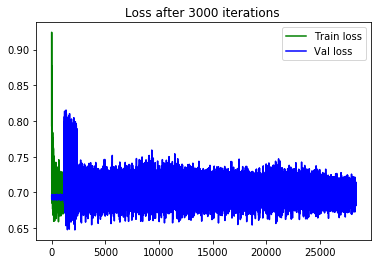

 42%|████▏     | 4000/9460 [05:30<03:53, 23.42it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 49 %


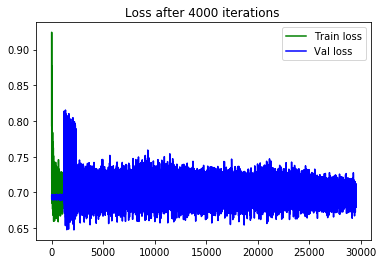

 53%|█████▎    | 5000/9460 [06:50<03:10, 23.43it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 50 %


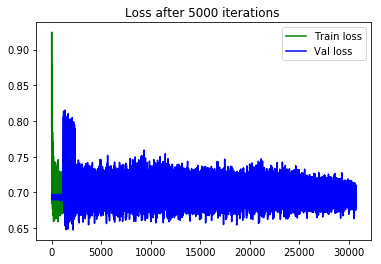

 63%|██████▎   | 6000/9460 [08:10<02:28, 23.35it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 50 %


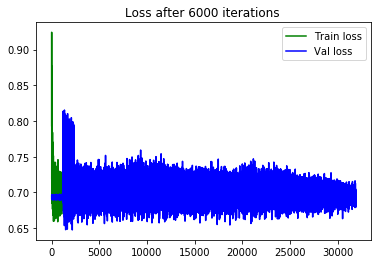

 74%|███████▍  | 7000/9460 [09:30<01:44, 23.44it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 50 %


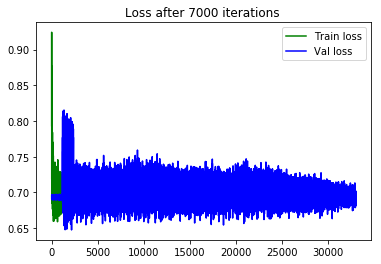

 85%|████████▍ | 8000/9460 [10:50<01:02, 23.42it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 50 %


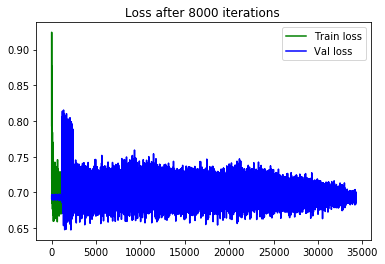

 95%|█████████▌| 9000/9460 [12:10<00:19, 23.37it/s]  

Accuracy of the network after 9000 iterations on the validation samples: 50 %


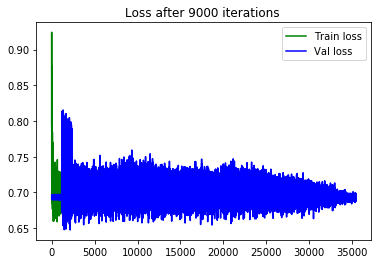

  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 3)
Accuracy of the network after 0 iterations on the validation samples: 50 %


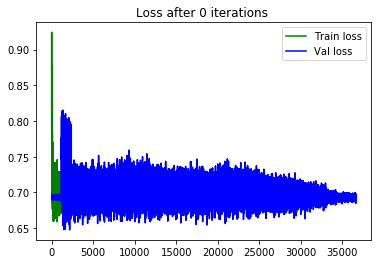

 11%|█         | 1000/9460 [01:30<06:01, 23.40it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 51 %


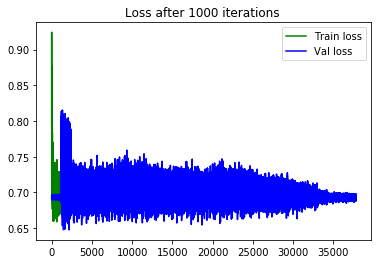

 21%|██        | 2000/9460 [02:50<05:18, 23.45it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 51 %


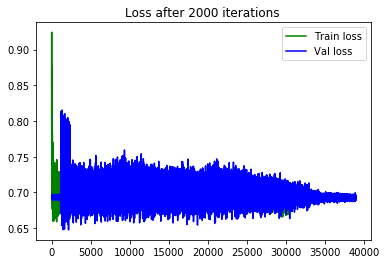

 32%|███▏      | 3000/9460 [04:10<04:35, 23.44it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 52 %


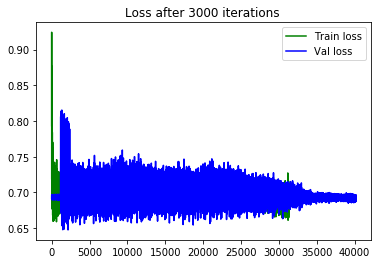

 42%|████▏     | 4000/9460 [05:30<03:53, 23.43it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 53 %


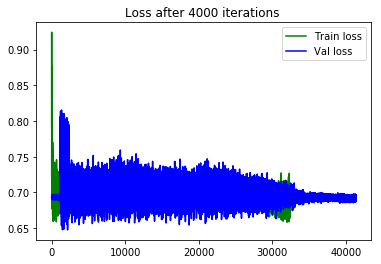

 53%|█████▎    | 5000/9460 [06:50<03:10, 23.44it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 53 %


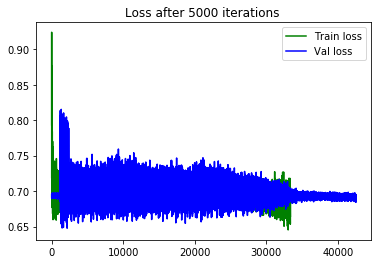

 63%|██████▎   | 6000/9460 [08:10<02:27, 23.43it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 54 %


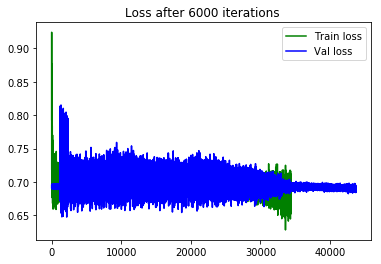

 74%|███████▍  | 7000/9460 [09:30<01:45, 23.41it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 55 %


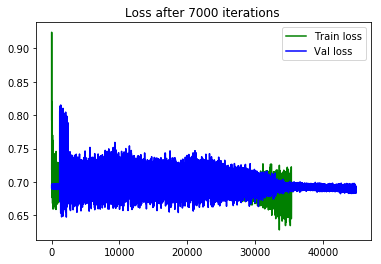

 85%|████████▍ | 8000/9460 [11:00<01:02, 23.48it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 56 %


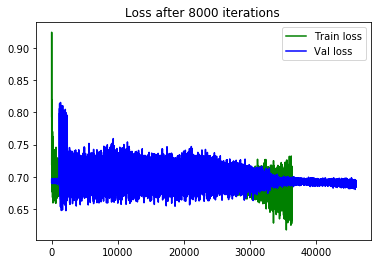

 95%|█████████▌| 9000/9460 [12:10<00:19, 23.45it/s]  

Accuracy of the network after 9000 iterations on the validation samples: 56 %


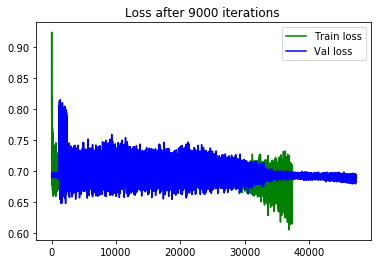

  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 4)
Accuracy of the network after 0 iterations on the validation samples: 57 %


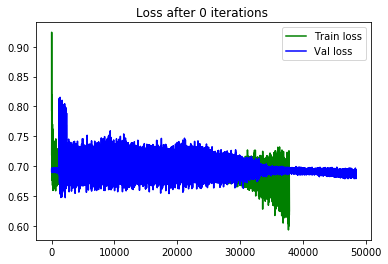

 11%|█         | 1000/9460 [01:30<06:01, 23.39it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 57 %


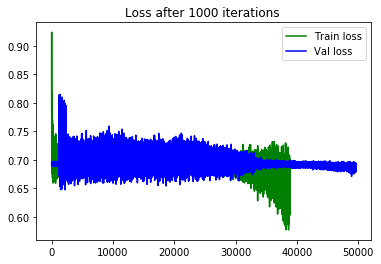

 21%|██        | 2000/9460 [02:50<05:18, 23.44it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 57 %


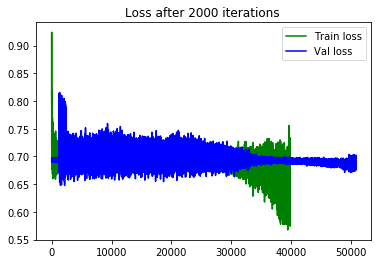

 32%|███▏      | 3000/9460 [04:10<04:35, 23.45it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 58 %


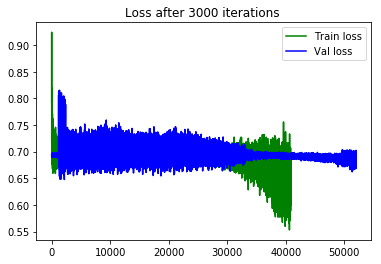

 42%|████▏     | 4000/9460 [05:30<03:53, 23.42it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 58 %


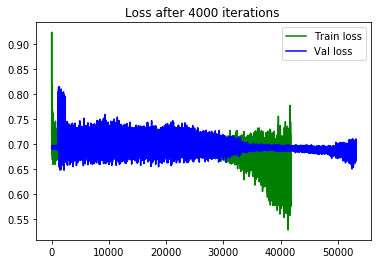

 53%|█████▎    | 5000/9460 [06:50<03:10, 23.44it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 59 %


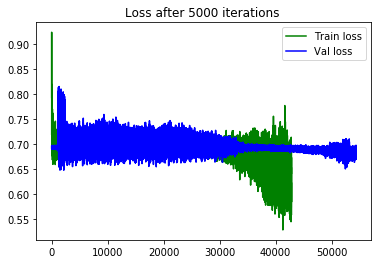

 63%|██████▎   | 6000/9460 [08:10<02:27, 23.47it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 59 %


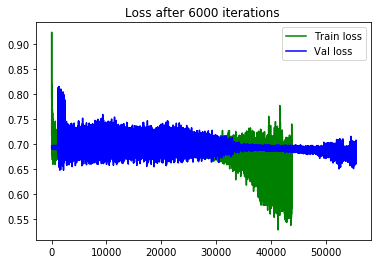

 74%|███████▍  | 7000/9460 [09:30<01:44, 23.53it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 59 %


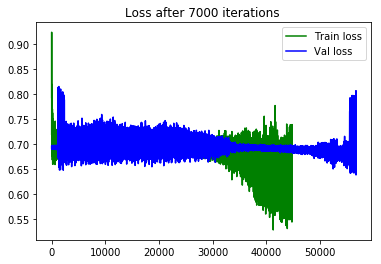

 85%|████████▍ | 8000/9460 [10:50<01:02, 23.39it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 59 %


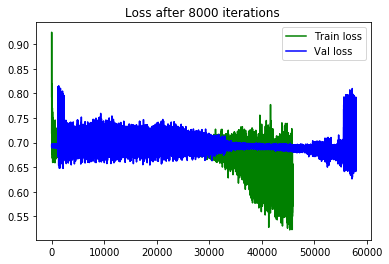

 95%|█████████▌| 9000/9460 [12:10<00:19, 23.42it/s]  

Accuracy of the network after 9000 iterations on the validation samples: 59 %


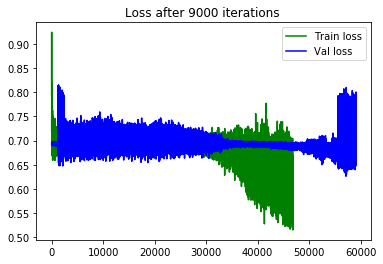

  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 5)
Accuracy of the network after 0 iterations on the validation samples: 59 %


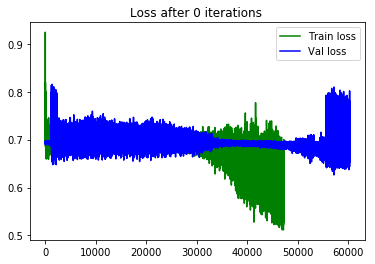

 11%|█         | 1000/9460 [01:30<06:01, 23.40it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 59 %


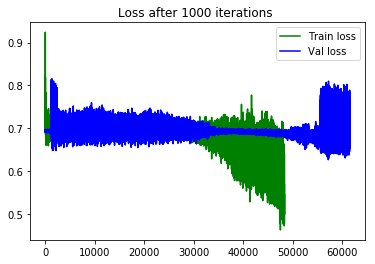

 21%|██        | 2000/9460 [03:00<05:19, 23.31it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 59 %


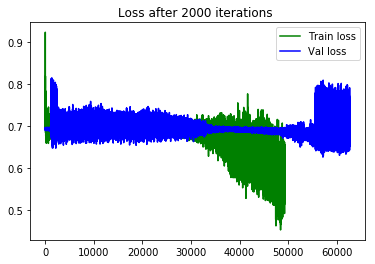

 32%|███▏      | 3000/9460 [04:20<04:35, 23.41it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 58 %


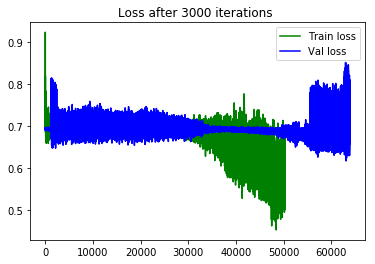

 42%|████▏     | 4000/9460 [05:40<03:51, 23.54it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 59 %


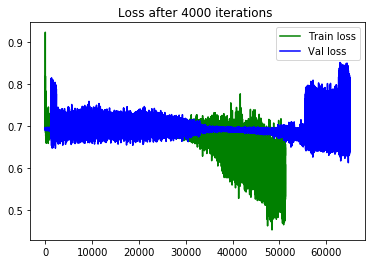

 53%|█████▎    | 5000/9460 [07:00<03:11, 23.35it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 59 %


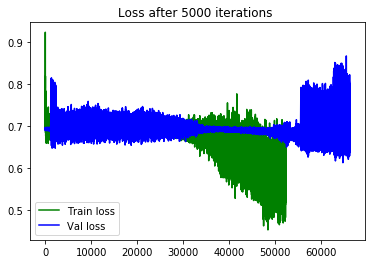

 63%|██████▎   | 6000/9460 [08:20<02:27, 23.46it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 60 %


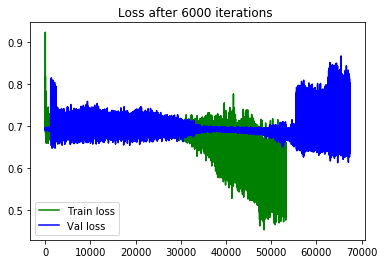

 74%|███████▍  | 7000/9460 [09:40<01:44, 23.51it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 59 %


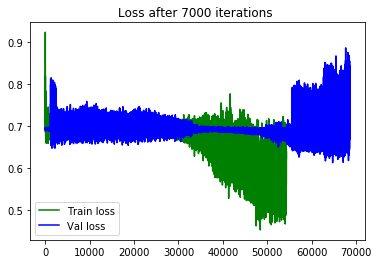

 85%|████████▍ | 8000/9460 [11:00<01:02, 23.53it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 59 %


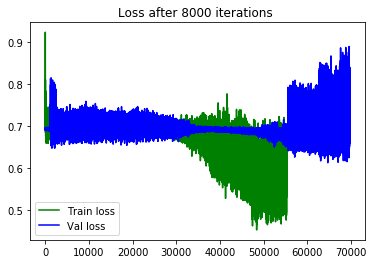

 95%|█████████▌| 9000/9460 [12:20<00:19, 23.45it/s]  

Accuracy of the network after 9000 iterations on the validation samples: 58 %


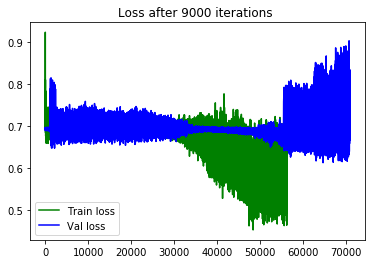

  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 6)
Accuracy of the network after 0 iterations on the validation samples: 58 %


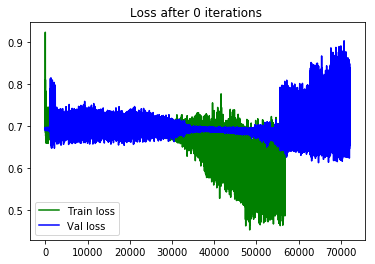

 11%|█         | 1000/9460 [01:40<06:01, 23.40it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 58 %


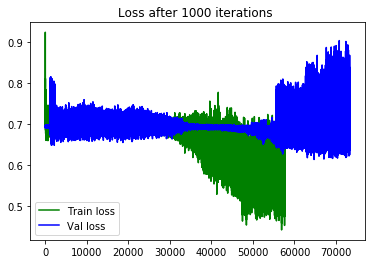

 21%|██        | 2000/9460 [03:00<05:17, 23.46it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 58 %


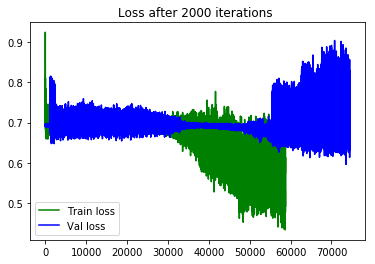

 32%|███▏      | 3000/9460 [04:20<04:35, 23.42it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 58 %


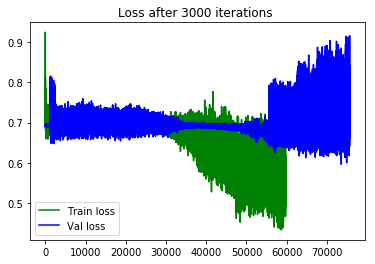

 42%|████▏     | 4000/9460 [05:40<03:52, 23.45it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 58 %


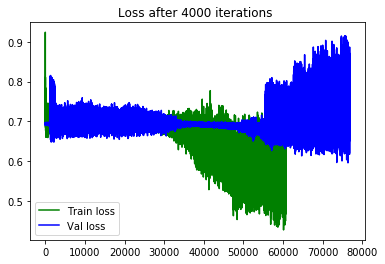

 53%|█████▎    | 5000/9460 [07:00<03:09, 23.49it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 58 %


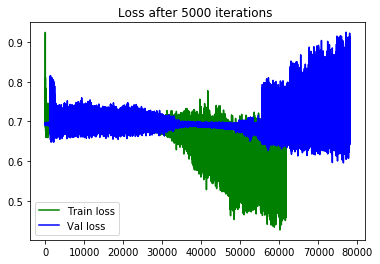

 63%|██████▎   | 6000/9460 [08:20<02:27, 23.39it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 59 %


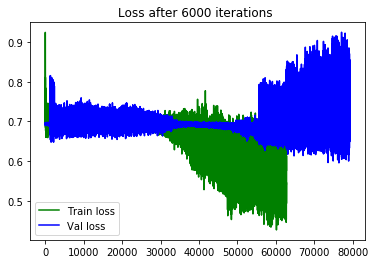

 74%|███████▍  | 7000/9460 [09:40<01:44, 23.51it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 59 %


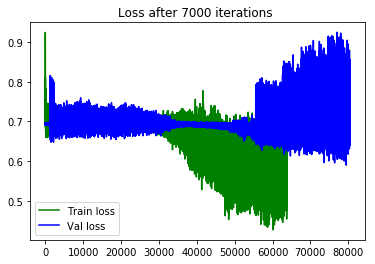

 85%|████████▍ | 8000/9460 [11:00<01:02, 23.42it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 58 %


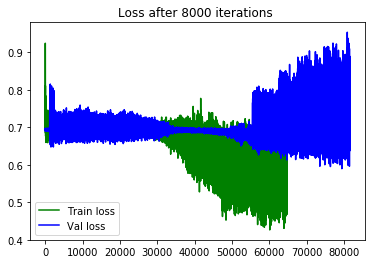

 95%|█████████▌| 9000/9460 [12:20<00:19, 23.49it/s]  

Accuracy of the network after 9000 iterations on the validation samples: 58 %


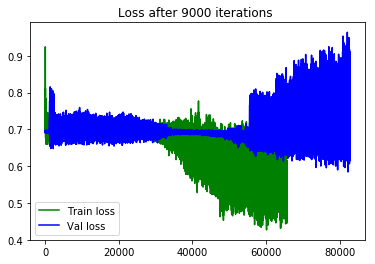

  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 7)
Accuracy of the network after 0 iterations on the validation samples: 59 %


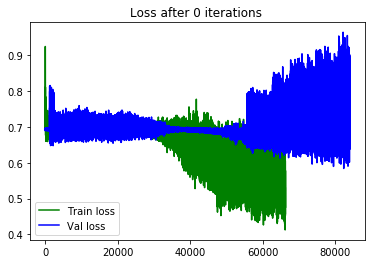

 11%|█         | 1000/9460 [01:30<05:59, 23.52it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 58 %


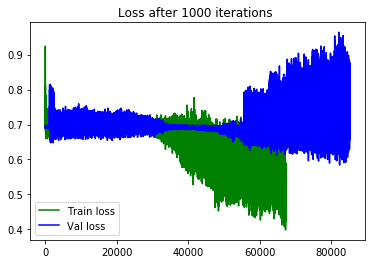

 21%|██        | 2000/9460 [03:00<05:29, 22.63it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 58 %


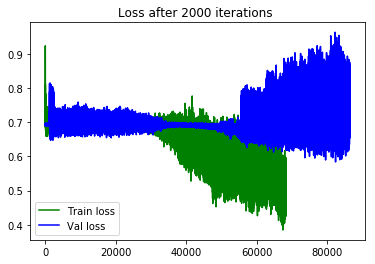

 32%|███▏      | 3000/9460 [04:20<04:34, 23.55it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 58 %


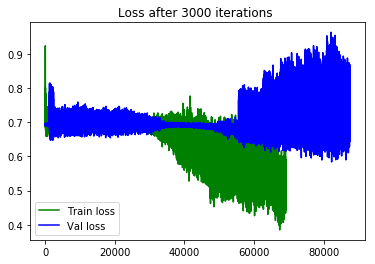

 42%|████▏     | 4000/9460 [05:40<03:53, 23.41it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 58 %


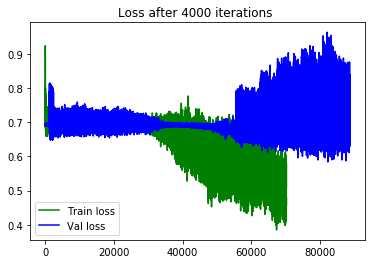

 53%|█████▎    | 5000/9460 [07:00<03:09, 23.49it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 58 %


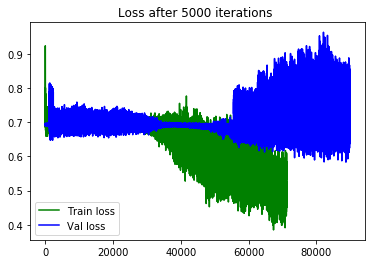

 63%|██████▎   | 6000/9460 [08:20<02:27, 23.48it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 58 %


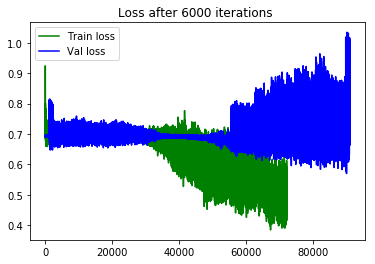

 74%|███████▍  | 7000/9460 [09:40<01:44, 23.45it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 58 %


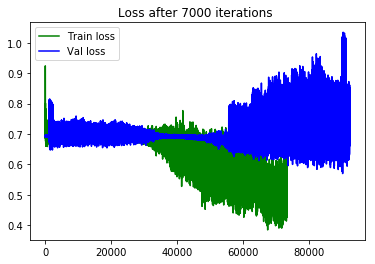

 85%|████████▍ | 8000/9460 [11:00<01:02, 23.49it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 58 %


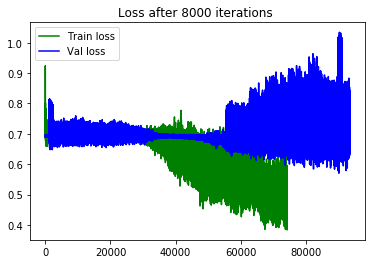

 95%|█████████▌| 9000/9460 [12:20<00:19, 23.35it/s]  

Accuracy of the network after 9000 iterations on the validation samples: 58 %


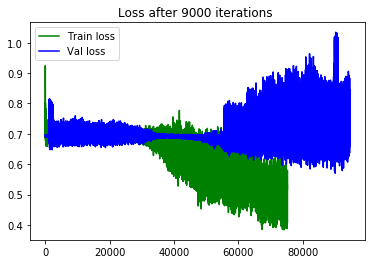

  0%|          | 0/9460 [00:00<?, ?it/s]

('Epoch: ', 8)
Accuracy of the network after 0 iterations on the validation samples: 59 %


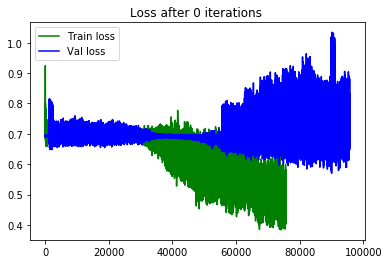

 11%|█         | 1000/9460 [01:40<06:01, 23.42it/s] 

Accuracy of the network after 1000 iterations on the validation samples: 58 %


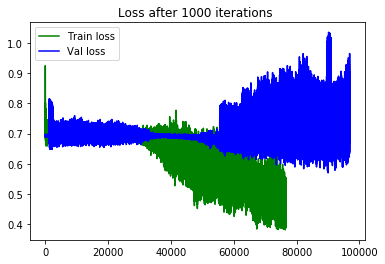

 21%|██        | 2000/9460 [03:00<05:16, 23.56it/s]   

Accuracy of the network after 2000 iterations on the validation samples: 57 %


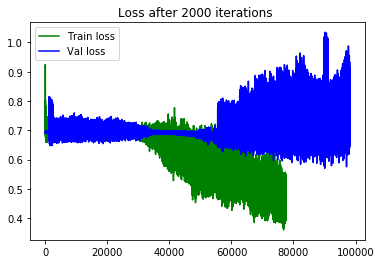

 32%|███▏      | 3000/9460 [04:20<04:35, 23.43it/s]   

Accuracy of the network after 3000 iterations on the validation samples: 58 %


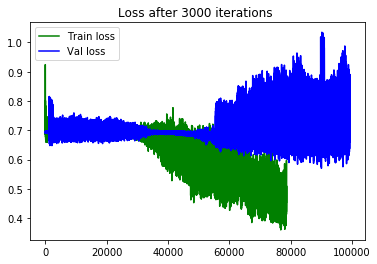

 42%|████▏     | 4000/9460 [05:40<03:52, 23.46it/s]   

Accuracy of the network after 4000 iterations on the validation samples: 58 %


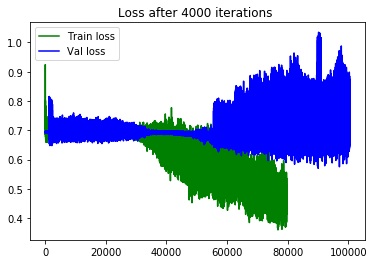

 53%|█████▎    | 5000/9460 [07:00<03:09, 23.50it/s]   

Accuracy of the network after 5000 iterations on the validation samples: 58 %


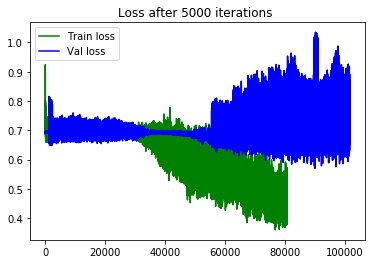

 63%|██████▎   | 6000/9460 [08:20<02:27, 23.51it/s]   

Accuracy of the network after 6000 iterations on the validation samples: 59 %


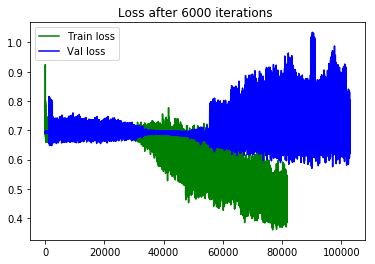

 74%|███████▍  | 7000/9460 [09:40<01:44, 23.45it/s]   

Accuracy of the network after 7000 iterations on the validation samples: 58 %


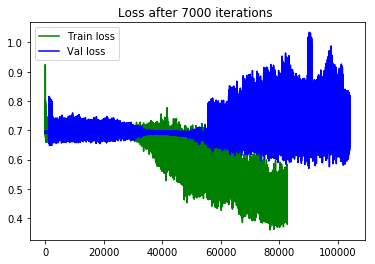

 85%|████████▍ | 8000/9460 [11:00<01:02, 23.54it/s]  

Accuracy of the network after 8000 iterations on the validation samples: 59 %


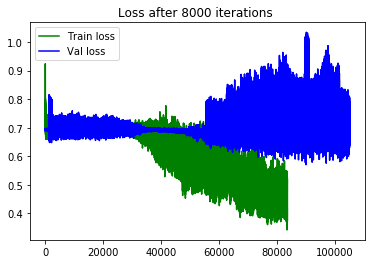

 95%|█████████▌| 9000/9460 [12:05<00:19, 23.57it/s]  

In [ ]:
lrs = [1e-3]
for lr in lrs:
    print("Initial learning rate: ", lr)
    binary_classification(t=10, lr=lr, decay=0)